In [59]:
using LinearAlgebra, Plots
gr()


# Generate the nxn Hilbert matrix with rational type entries (// operator)
Hil(n::Int) = [1//(i+j-1) for i in 1:n, j in 1:n]


# plot hilbert matrix 2-norm condition numbers
function plot_hil_conds()
    conds = []
    nn = collect(4:12)
    for n in nn
        push!(conds, cond(Hil(n)))
    end
    
    p = plot(title="Hilbert matrix 2-norm condition numbers vs dimension",
        xlabel="dimension", ylabel="condition number",
        yaxis=:log, size=(900,900))
    
    plot!(p, nn, conds, lc=:teal, lw=4, label="")
    scatter!(p, nn, conds, mc=:gold, ms=5, label="")
    
#     p
    png("hilbert conditions")
end


# Newton's divided difference polynomial
function ndd(; data)
    n = length(data)
    # initialize nxm matrix
    m = zeros(Float64, n, n)
    
    # unzips list of (x,y) coords into separate lists
    # set first column of DD matrix to f(x) for x in xx
    xx, yy = map(y -> map(x -> x[y], data), 1:2)
    m[:,1] = yy
    xrng = collect(minimum(xx):0.01:maximum(xx))
    
    # generate lower triangular NDD matrix
    for i in 2:n
        for j in 2:i
            m[i,j] = (m[i,j-1]-m[i-1,j-1])/(xx[i]-xx[i-j+1])
        end
    end

    # sum the diagonal entries as coefficients
    # on the generated Newton polynomial
    f(x) = sum(m[i,i]*poly(i, x, xx) for i in 1:n)
    
    p = plot(title="newton's divided differences polynomial degree $(n-1)",
        xlabel="x", ylabel="y", size=(900,900))
    
    plot!(p, xrng, f.(xrng), lw=4, lc=:teal, label="")
    scatter!(p, xx, yy, mc=:gold, ms=5, label="")
    
#     p
    png("ndd_$(n-1)")
end


# Helper function to generate Newton polynomials
function poly(i, x, xx)
    p = 1
    for j in 1:i-1
        p *= (x-xx[j]) # (x - xj) for j from 1 to i-1
    end
    return p
end


# Cubic spline solver, defaults to free boundary conditions
function cspl(; data, bc="free")
    xx, yy = map(y -> map(x -> x[y], data), 1:2)
    
    # number of splines, number of interior points, etc
    nsp = length(xx) - 1
    inter = nsp - 1
    n = 2*nsp

    # Initialize a matrix
    m = zeros(2*n, 2*n)

    # Partition the columns into sets of four
    p = [4*(j-1) .+ [i for i in 1:4] for j in 1:nsp]
    
    # Construct the solution vector
    zz = fill(0.0, 2*n)
    zz[1] = yy[1]
    zz[n] = yy[end]
    for i in 2:inter+1
        j = 2*(i-2) .+ [1,2]

        zz[j[1]+1] = yy[i]
        zz[j[2]+1] = yy[i]
    end
    
    # s, s', s'' coefficients
    coefs = [[1,1,1,1], [0,1,2,3], [0,0,2,6]]
    exps = [[0,1,2,3], [0,0,1,2], [0,0,0,1]]

    # s, s', s'' general forms as lambda expressions
    s = [x -> coefs[1][j]*(x-xi)^exps[1][j] for xi in xx[1:end-1], j in 1:4]
    ds = [x -> coefs[2][j]*(x-xi)^exps[2][j] for xi in xx[1:end-1], j in 1:4]
    dds = [x -> coefs[3][j]*(x-xi)^exps[3][j] for xi in xx[1:end-1], j in 1:4]
    
    # store s, s', s'' in a single matrix
    s = vcat(s, vcat(ds, dds))

    # Evaluate spline lambdas at a given x value
    function seval(s, x)
        return [round(f(x), digits=5) for f in s]
    end

    # this loop fills in the first 2*(number of splines) rows
    # where each pair of rows corresponds to a single spline
    # evaluated at its two end points
    j=1
    for i in 1:2:n
        j = mod1(j, nsp)
        m[i, p[j]] = seval(s[j,:], xx[j])
        m[i+1, p[j]] = seval(s[j,:], xx[j+1])
        j += 1
    end

    # this loop fills in the next 2*(number of interior points) rows
    # where each row consists of the first derivatives of adjacent splines
    # evaluated at the boundary between the two splines
    # and each row after the all the first derivatives then evaluates
    # all of the second derivatives
    for i in 1:inter
        q = mod1(i, nsp)

        # s' is evaluated at each spline transition
        # the second 'seval' is negative which corresponds to
        # subtracting the (i+1)th spline on the (i)th spline's side
        m[i+n, p[q]] = seval(s[i+nsp,:], xx[i+1])
        m[i+n, p[q+1]] = -seval(s[i+nsp+1,:], xx[i+1])

        # s'' is evaluated at each spline transition
        m[i+n+inter, p[q]] = seval(s[i+n,:], xx[i+1])
        m[i+n+inter, p[q+1]] = -seval(s[i+n+1,:], xx[i+1])
    end

    if bc == "free"
        boundary_conds = "free boundary conditions"
        m[end-1, p[1]] = seval(s[1+n,:], xx[1]) 
        m[end, p[end]] = seval(s[3*nsp,:], xx[end])
    elseif bc == "nk"
        boundary_conds = "not-a-knot boundary conditions"
        m[end-1,:] = vcat([0, 0, 0, 6, 0, 0, 0, -6], fill(0.0, 2*n-8))
        m[end,:] = vcat(fill(0.0, 2*n-8), [0, 0, 0, 6, 0, 0, 0, -6])
    else
        println("please specify valid boundary conditions!")
        return false
    end

    # Solve for the coefficients
    z = m\zz
    
    # Partition coefficients into sets of four
    z =  [[z[4*(j-1)+i] for i in 1:4] for j in 1:nsp]
    soln = []
    plot_intvls = []

    # Construct the splines with the given coefficients
    # then store the splines in a vector to return
    for i in 1:length(z)
        push!(soln, x -> sum(z[i][j]*(x-xx[i])^(j-1) for j in 1:4))
    end
    
    for i in 2:length(soln)+1
        push!(plot_intvls, collect(xx[i-1]:0.0001:xx[i]))
    end
    
    p = plot(title="cubic splines interpolation using $(boundary_conds)",
        xlabel="x", ylabel="y", size=(900,900))
    
    for (spline, intvl) in zip(soln, plot_intvls)
        plot!(p, intvl, spline.(intvl), lw=4, lc=:teal, label="")
    end
    
    scatter!(p, xx, yy, mc=:gold, ms=5, label="")
    
#     p
    png("cubic_spline")
end;


# polynomial least squares
function lsfit(; data, n)
    n += 1
    xx, yy = map(y -> map(x -> x[y], data), 1:2)
    xrng = collect(minimum(xx):0.01:maximum(xx))
    
    A = Array{Float64}(undef, (n,n))
    b = [sum(yy[i]*xx[i]^j for i in 1:length(xx)) for j in 0:n-1]

    for i in 1:n
        for j in 1:n
            A[i,j] = sum(xx[k]^(i+j-2) for k in 1:length(xx))
        end
    end

    coefs = A\b

    f(x) = sum(coefs[i]*x^(i-1) for i in 1:n)
    
    p = plot(title="polynomial least squares data fit of degree $(n-1)",
            xlabel="x", ylabel="y", size=(900,900))
    
    plot!(p, xrng, f.(xrng), lw=4, lc=:teal, label="")
    scatter!(p, xx, yy, mc=:gold, ms=5, label="")
    
    return p
end;

In [27]:
plot_hil_conds()

In [29]:
ndd(data=qdat)

In [9]:
cspl(data=qdat, bc="nk")

UndefVarError: UndefVarError: cspl not defined

In [7]:
q(t) = -11 + 55/3 * t - 17/2 * t^2 + 7/6 * t^3
qrange = collect(0.9:(3.2/32.0):4.1)
qq = q.(qrange)
qq = [qx + (0.3*rand() - 0.15) for qx in qq]
qdat = [(x,y) for (x,y) in zip(qrange, qq)];

In [6]:
using LinearAlgebra, Plots
gr()

# polynomial least squares
function lsfit(; data, n)
    xx, yy = map(y -> map(x -> x[y], data), 1:2)
    xrng = collect(minimum(xx):0.01:maximum(xx))
    
    A = xx.^collect(0:n)'
    coefs = (A'A)\(A'yy)

    f(x) = sum(c*x^(i-1) for (i, c) in enumerate(coefs))
    p = plot(title="polynomial least squares data fit of degree $(n-1)",
        xlabel="x", ylabel="y", size=(900,900))
    
    plot!(p, xrng, f.(xrng), lw=4, lc=:teal, label="")
    scatter!(p, xx, yy, mc=:gold, ms=5, label="")
    
    return p
end

lsfit (generic function with 1 method)

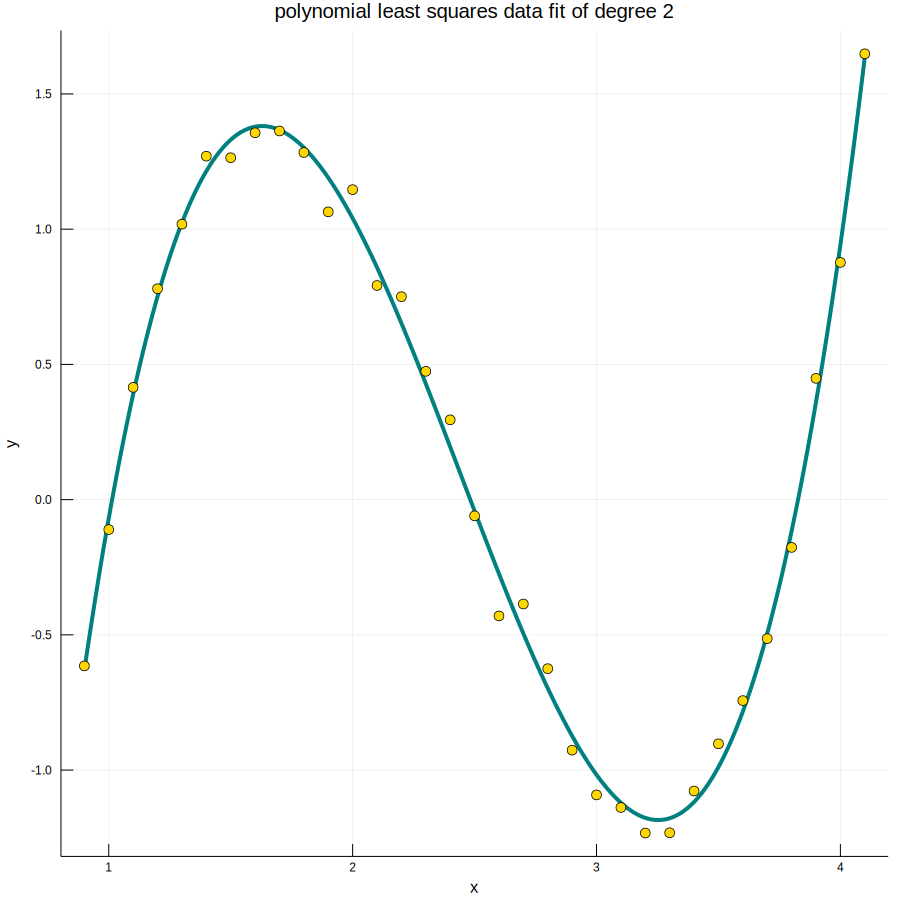

In [8]:
lsfit(data=qdat, n=3)

In [38]:
dat = [(1.0, 1.84), (1.1, 1.96), (1.3, 2.21), (1.5, 2.45), (1.9, 2.94), (2.1, 3.18)]

6-element Array{Tuple{Float64,Float64},1}:
 (1.0, 1.84)
 (1.1, 1.96)
 (1.3, 2.21)
 (1.5, 2.45)
 (1.9, 2.94)
 (2.1, 3.18)

In [39]:
dat = [(1.0, 1.84), (1.1, 1.96), (1.3, 2.21), (1.5, 2.45), (1.9, 2.94), (2.1, 3.18)]

xx, yy = map(y -> map(x -> x[y], dat), 1:2)
xrng = collect(minimum(xx):0.01:maximum(xx))

p1 = lsfit(data=dat, n=1)
p2 = lsfit(data=dat, n=2)
p3 = lsfit(data=dat, n=3)
p32 = lsfit(data=dat, n=32)

e1 = sum((yy[i]-p1(xx[i]))^2 for i in 1:length(xx))
e2 = sum((yy[i]-p2(xx[i]))^2 for i in 1:length(xx))
e3 = sum((yy[i]-p3(xx[i]))^2 for i in 1:length(xx))
e32 = sum((yy[i]-p32(xx[i]))^2 for i in 1:length(xx))

println("e1: $(e1)\ne2: $(e2)\ne3: $(e3)\ne32: $(e32)")

p = plot(legend=:topleft, xlabel="x", ylabel="y", size=(900,900))
    
plot!(p, xrng, p1.(xrng), lw=4, lc=:teal, label="deg 1")
plot!(p, xrng, p2.(xrng), lw=4, lc=:gold, label="deg 2")
plot!(p, xrng, p3.(xrng), lw=4, lc=:pink, label="deg 3")
plot!(p, xrng, p32.(xrng), lw=4, lc=:black, label="deg 32")
scatter!(p, xx, yy, mc=:violet, ms=5, label="data")

png("unstable fit")

MethodError: MethodError: objects of type Plots.Plot{Plots.GRBackend} are not callable

In [1]:
using Plots
gr()

Plots.GRBackend()

In [8]:
using LinearAlgebra, Plots
gr()

t1 = [i/10 for i in 0:5]
t2 = [i/10 for i in 6:10]

b1 = [0.9, 1.01, 1.05, 0.97, 0.98, 0.95]
b2 = [0.01, -0.1, 0.02, -0.1, 0.0]

A1 = [1.0 for i in 1:length(t1), j in 1:2]
A1[:,2] = t1

A2 = [1.0 for i in 1:length(t2), j in 1:2]
A2[:,2] = t2

AT1 = A1'A1
AT2 = A2'A2

bb1 = A1'b1
bb2 = A2'b2

c1, m1 = AT1\bb1
c2, m2 = AT2\bb2

f1(x) = m1*x + c1
f2(x) = m2*x + c2;

In [13]:
tt = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bb = [0.9, 1.01, 1.05, 0.97, 0.98, 0.95, 0.01, -0.1, 0.02, -0.1, 0.0]

plot(tt, bb, lw=4, lc=:violet, label="")

x1 = collect(0.0:0.01:0.55)
x2 = collect(0.55:0.01:1.0)

plot!(title="step function from data")
plot!(x1, f1.(x1), lw=4, lc=:gold, label="")
plot!(x2, f2.(x2), lw=4, lc=:gold, label="")
scatter!(tt, bb, mc=:teal, ms=5, size=(800,800), label="fake data")

png("step function")